The PAMAP2 data is collection of physical activities performed during daily routine with the aim to develop new approaches for recognising intensities of activities, which can be used along with wearable technologies to monitor and improve individuals’ health. The data concentrates on the intensity of performed activities and classifies them as light, moderate and vigorous.9 participants with healthy BMI, performed 24 activities and the data was collected with 3sensors and a heart rate monitor. Though, the data was collected for 10hours, only 8hours of data is labelled while some data is missing due to wireless data dropping. The labelled data is available in the dat file for processing. The objective of the report is to understand and evaluate  physical activity data to develop actionable plan for developing software or hardware.

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split

import seaborn as sns
import statsmodels as sm

In [2]:
import os
working_directory= os.getcwd()
print(working_directory)

/Users/rakhee/DSRM_data_set


In [3]:
path= working_directory+'/DSRM_data_set/Protocol'

In [4]:
allfiles = ['/Users/rakhee/DSRM_data_set/Protocol/subject101.dat',
            '/Users/rakhee/DSRM_data_set/Protocol/subject102.dat',
            '/Users/rakhee/DSRM_data_set/Protocol/subject103.dat',
            '/Users/rakhee/DSRM_data_set/Protocol/subject104.dat',
            '/Users/rakhee/DSRM_data_set/Protocol/subject105.dat',
            '/Users/rakhee/DSRM_data_set/Protocol/subject106.dat',
            '/Users/rakhee/DSRM_data_set/Protocol/subject107.dat',
            '/Users/rakhee/DSRM_data_set/Protocol/subject108.dat',
            '/Users/rakhee/DSRM_data_set/Protocol/subject109.dat' ]

subjectID = [1,2,3,4,5,6,7,8,9]

activityIDdict = {0: 'transient',
              1: 'lying',
              2: 'sitting',
              3: 'standing',
              4: 'walking',
              5: 'running',
              6: 'cycling',
              7: 'Nordic_walking',
              9: 'watching_TV',
              10: 'computer_work',
              11: 'car driving',
              12: 'ascending_stairs',
              13: 'descending_stairs',
              16: 'vacuum_cleaning',
              17: 'ironing',
              18: 'folding_laundry',
              19: 'house_cleaning',
              20: 'playing_soccer',
              24: 'rope_jumping' }


colNames = ["timestamp", "activityID","heartrate"]

IMUhand = ['handtemp', 
           'handAcc16_1', 'handAcc16_2', 'handAcc16_3', 
           'handAcc6_1', 'handAcc6_2', 'handAcc6_3', 
           'handGyro1', 'handGyro2', 'handGyro3', 
           'handMagne1', 'handMagne2', 'handMagne3',
           'handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4']

IMUchest = ['chesttemp', 
           'chestAcc16_1', 'chestAcc16_2', 'chestAcc16_3', 
           'chestAcc6_1', 'chestAcc6_2', 'chestAcc6_3', 
           'chestGyro1', 'chestGyro2', 'chestGyro3', 
           'chestMagne1', 'chestMagne2', 'chestMagne3',
           'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4']

IMUankle = ['ankletemp', 
           'ankleAcc16_1', 'ankleAcc16_2', 'ankleAcc16_3', 
           'ankleAcc6_1', 'ankleAcc6_2', 'ankleAcc6_3', 
           'ankleGyro1', 'ankleGyro2', 'ankleGyro3', 
           'ankleMagne1', 'ankleMagne2', 'ankleMagne3',
           'ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4']

columns = colNames + IMUhand + IMUchest + IMUankle 

len(columns)

54

In [5]:
dataset = pd.DataFrame()

for f in allfiles:
    pdata = pd.read_table(f, header=None, sep='\s+')
    pdata.columns = columns
    pdata['subject_id'] = int(f[-5])
    dataset = dataset.append(pdata, ignore_index=True)

dataset.reset_index(drop=True, inplace=True)

Data Cleaning and wrangling

 The data has over 55 columns and over 3093966 entries. Most missing data, about 90% is from the heartrate column while some entries in other columns are also missing information. These  missing entries need to be dropped or filled with mean or null values. Dropping data with missing values will drastically reduce the data set, further reducing the ability to draw any valid conclusions. Also, heartrate is a critical column which is affected by activities and sensor values. The first few values of the heartrate column are 0, but as the activity in all rows is the same activity, it is acceptable to fill the missing values with the next available value in the column which is 100. The remaining missing values in the column are filled using interpolation. This is to ensure that missing data for light activities are not filled with very high mean and vice versa. Other missing values in chest temperature, hand temperature ankle temperature along with any missing sensor value are filled with 0. Column for
 Activity==0, is dropped from the dataset, as it is a recording in-between activity and does not add value to the dataset. Further, data columns recording orientation of hand, ankel and chest are dropped.


In [7]:
dataset.shape


(2872533, 55)

In [8]:
dataset.iloc[:,-1]

0          1
1          1
2          1
3          1
4          1
          ..
2872528    9
2872529    9
2872530    9
2872531    9
2872532    9
Name: subject_id, Length: 2872533, dtype: int64

In [9]:
dataset.isnull().sum().sum()

3093966

In [10]:
dataset

,timestamp,activityID,heartrate,handtemp,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,...,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,ankleOrientation1,ankleOrientation2,ankleOrientation3,ankleOrientation4,subject_id
0,8.38,0,104.0,30.0000,2.37223,8.60074,3.51048,2.43954,8.76165,3.35465,...,0.009250,-0.017580,-61.1888,-38.95990,-58.143800,1.000000,0.000000,0.000000,0.000000,1
1,8.39,0,NaN,30.0000,2.18837,8.56560,3.66179,2.39494,8.55081,3.64207,...,-0.004638,0.000368,-59.8479,-38.89190,-58.525300,1.000000,0.000000,0.000000,0.000000,1
2,8.40,0,NaN,30.0000,2.37357,8.60107,3.54898,2.30514,8.53644,3.73280,...,0.000148,0.022495,-60.7361,-39.41380,-58.399900,1.000000,0.000000,0.000000,0.000000,1
3,8.41,0,NaN,30.0000,2.07473,8.52853,3.66021,2.33528,8.53622,3.73277,...,-0.020301,0.011275,-60.4091,-38.76350,-58.395600,1.000000,0.000000,0.000000,0.000000,1
4,8.42,0,NaN,30.0000,2.22936,8.83122,3.70000,2.23055,8.59741,3.76295,...,-0.014303,-0.002823,-61.5199,-39.38790,-58.269400,1.000000,0.000000,0.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2872528,100.19,0,NaN,25.1875,-4.71493,10.22250,4.66893,-5.04654,9.94944,4.50736,...,-0.062676,-0.127084,-46.5153,3.58240,-0.035995,0.598531,0.033615,0.799791,-0.031075,9
2872529,100.20,0,NaN,25.1875,-4.95932,10.37130,4.12594,-4.96890,10.29620,4.43102,...,-0.027006,-0.089808,-45.7474,3.54453,0.108583,0.598428,0.033012,0.799933,-0.030018,9
2872530,100.21,0,NaN,25.1875,-4.93997,9.83615,3.70468,-5.04613,10.35690,4.14405,...,-0.038024,-0.064709,-46.3997,4.22078,0.105504,0.598233,0.033172,0.800095,-0.029416,9
2872531,100.22,0,NaN,25.1875,-4.64941,9.11129,3.51904,-5.06854,9.75268,3.87359,...,-0.025796,-0.064357,-46.5282,4.48593,0.530240,0.598116,0.033427,0.800180,-0.029208,9


In [11]:
dataset.isnull().sum()

timestamp                  0
activityID                 0
heartrate            2610265
handtemp               13141
handAcc16_1            13141
handAcc16_2            13141
handAcc16_3            13141
handAcc6_1             13141
handAcc6_2             13141
handAcc6_3             13141
handGyro1              13141
handGyro2              13141
handGyro3              13141
handMagne1             13141
handMagne2             13141
handMagne3             13141
handOrientation1       13141
handOrientation2       13141
handOrientation3       13141
handOrientation4       13141
chesttemp               3563
chestAcc16_1            3563
chestAcc16_2            3563
chestAcc16_3            3563
chestAcc6_1             3563
chestAcc6_2             3563
chestAcc6_3             3563
chestGyro1              3563
chestGyro2              3563
chestGyro3              3563
chestMagne1             3563
chestMagne2             3563
chestMagne3             3563
chestOrientation1       3563
chestOrientati

In [12]:
dataset2=dataset.drop(dataset[dataset.activityID == 0].index)

In [13]:
dataset2.head(10)

,timestamp,activityID,heartrate,handtemp,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,...,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,ankleOrientation1,ankleOrientation2,ankleOrientation3,ankleOrientation4,subject_id
2928,37.66,1,NaN,30.375,2.21530,8.27915,5.58753,2.24689,8.55387,5.77143,...,-0.027714,0.001752,-61.1081,-36.8636,-58.3696,1.0,0.0,0.0,0.0,1
2929,37.67,1,NaN,30.375,2.29196,7.67288,5.74467,2.27373,8.14592,5.78739,...,0.000945,0.006007,-60.8916,-36.3197,-58.3656,1.0,0.0,0.0,0.0,1
2930,37.68,1,NaN,30.375,2.29090,7.14240,5.82342,2.26966,7.66268,5.78846,...,-0.052422,-0.004882,-60.3407,-35.7842,-58.6119,1.0,0.0,0.0,0.0,1
2931,37.69,1,NaN,30.375,2.21800,7.14365,5.89930,2.22177,7.25535,5.88000,...,-0.018844,0.026950,-60.7646,-37.1028,-57.8799,1.0,0.0,0.0,0.0,1
2932,37.70,1,100.0,30.375,2.30106,7.25857,6.09259,2.20720,7.24042,5.95555,...,-0.048878,-0.006328,-60.2040,-37.1225,-57.8847,1.0,0.0,0.0,0.0,1
2933,37.71,1,NaN,30.375,2.07165,7.25965,6.01218,2.19238,7.21038,6.01604,...,-0.026906,0.004125,-61.3257,-36.9744,-57.7501,1.0,0.0,0.0,0.0,1
2934,37.72,1,NaN,30.375,2.41148,7.59780,5.93915,2.23988,7.46679,6.03053,...,-0.032277,-0.006866,-61.5520,-36.9632,-57.9957,1.0,0.0,0.0,0.0,1
2935,37.73,1,NaN,30.375,2.32815,7.63431,5.70686,2.31663,7.64745,6.01495,...,-0.016621,0.006548,-61.5738,-36.1724,-59.3487,1.0,0.0,0.0,0.0,1
2936,37.74,1,NaN,30.375,2.25096,7.78598,5.62821,2.28637,7.70801,5.93935,...,0.020393,-0.011880,-61.7741,-37.1744,-58.1199,1.0,0.0,0.0,0.0,1
2937,37.75,1,NaN,30.375,2.14107,7.52262,5.78141,2.31538,7.72276,5.78828,...,-0.010763,0.005133,-60.7680,-37.4206,-58.8735,1.0,0.0,0.0,0.0,1


In [14]:
for i in range(0,4):
    dataset2["heartrate"].iloc[i]=100

/Users/rakhee/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [15]:
dataset2.head(20)

,timestamp,activityID,heartrate,handtemp,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,...,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,ankleOrientation1,ankleOrientation2,ankleOrientation3,ankleOrientation4,subject_id
2928,37.66,1,100.0,30.375,2.21530,8.27915,5.58753,2.24689,8.55387,5.77143,...,-0.027714,0.001752,-61.1081,-36.8636,-58.3696,1.0,0.0,0.0,0.0,1
2929,37.67,1,100.0,30.375,2.29196,7.67288,5.74467,2.27373,8.14592,5.78739,...,0.000945,0.006007,-60.8916,-36.3197,-58.3656,1.0,0.0,0.0,0.0,1
2930,37.68,1,100.0,30.375,2.29090,7.14240,5.82342,2.26966,7.66268,5.78846,...,-0.052422,-0.004882,-60.3407,-35.7842,-58.6119,1.0,0.0,0.0,0.0,1
2931,37.69,1,100.0,30.375,2.21800,7.14365,5.89930,2.22177,7.25535,5.88000,...,-0.018844,0.026950,-60.7646,-37.1028,-57.8799,1.0,0.0,0.0,0.0,1
2932,37.70,1,100.0,30.375,2.30106,7.25857,6.09259,2.20720,7.24042,5.95555,...,-0.048878,-0.006328,-60.2040,-37.1225,-57.8847,1.0,0.0,0.0,0.0,1
2933,37.71,1,NaN,30.375,2.07165,7.25965,6.01218,2.19238,7.21038,6.01604,...,-0.026906,0.004125,-61.3257,-36.9744,-57.7501,1.0,0.0,0.0,0.0,1
2934,37.72,1,NaN,30.375,2.41148,7.59780,5.93915,2.23988,7.46679,6.03053,...,-0.032277,-0.006866,-61.5520,-36.9632,-57.9957,1.0,0.0,0.0,0.0,1
2935,37.73,1,NaN,30.375,2.32815,7.63431,5.70686,2.31663,7.64745,6.01495,...,-0.016621,0.006548,-61.5738,-36.1724,-59.3487,1.0,0.0,0.0,0.0,1
2936,37.74,1,NaN,30.375,2.25096,7.78598,5.62821,2.28637,7.70801,5.93935,...,0.020393,-0.011880,-61.7741,-37.1744,-58.1199,1.0,0.0,0.0,0.0,1
2937,37.75,1,NaN,30.375,2.14107,7.52262,5.78141,2.31538,7.72276,5.78828,...,-0.010763,0.005133,-60.7680,-37.4206,-58.8735,1.0,0.0,0.0,0.0,1


In [16]:
dataset2=dataset2.interpolate()

In [17]:
dataset2['heartrate'].median()

104.0

In [18]:
dataset2['heartrate'].mean()

107.48790990863012

In [19]:
dataset2.isnull().sum().sum()

0

In [20]:
dataset2.describe()

,timestamp,activityID,heartrate,handtemp,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,...,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,ankleOrientation1,ankleOrientation2,ankleOrientation3,ankleOrientation4,subject_id
count,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,...,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06
mean,1.705202e+03,8.081830e+00,1.074879e+02,3.275126e+01,-4.952973e+00,3.585079e+00,3.602232e+00,-4.886286e+00,3.573597e+00,3.786931e+00,...,-3.652767e-02,6.658552e-03,-3.158971e+01,1.396960e+00,1.725039e+01,3.812299e-01,-8.998437e-03,3.023855e-01,-5.698127e-02,4.566387e+00
std,1.093463e+03,6.174789e+00,2.699215e+01,1.794162e+00,6.239663e+00,6.893705e+00,3.956957e+00,6.245972e+00,6.589666e+00,3.942860e+00,...,6.383285e-01,2.012898e+00,1.834639e+01,2.168678e+01,1.970652e+01,3.036803e-01,5.714335e-01,3.326730e-01,4.800388e-01,2.333052e+00
min,3.120000e+01,1.000000e+00,5.700000e+01,2.487500e+01,-1.453670e+02,-1.043010e+02,-1.014520e+02,-6.121470e+01,-6.184170e+01,-6.193470e+01,...,-1.812690e+01,-1.401960e+01,-1.728650e+02,-1.379080e+02,-1.027160e+02,1.521280e-06,-9.568760e-01,-8.768380e-01,-9.972810e-01,1.000000e+00
25%,7.445400e+02,3.000000e+00,8.600000e+01,3.168750e+01,-8.969760e+00,1.058210e+00,1.161470e+00,-8.866490e+00,1.057690e+00,1.363370e+00,...,-1.066082e-01,-4.416998e-01,-4.171632e+01,-1.248465e+01,3.794668e+00,1.426340e-01,-6.129580e-01,4.914657e-03,-5.378710e-01,2.000000e+00
50%,1.480330e+03,6.000000e+00,1.040000e+02,3.312500e+01,-5.450280e+00,3.526550e+00,3.431410e+00,-5.378515e+00,3.567850e+00,3.662640e+00,...,-3.950165e-03,-2.327570e-03,-3.400820e+01,7.769370e-01,1.876755e+01,2.838390e-01,0.000000e+00,3.055330e-01,0.000000e+00,5.000000e+00
75%,2.663610e+03,1.300000e+01,1.240000e+02,3.406250e+01,-9.577087e-01,6.453505e+00,6.531523e+00,-9.058870e-01,6.458670e+00,6.775980e+00,...,1.162570e-01,9.181807e-02,-1.790600e+01,1.783892e+01,3.121160e+01,5.600202e-01,6.153723e-01,5.960633e-01,4.382870e-01,7.000000e+00
max,4.245680e+03,2.400000e+01,2.020000e+02,3.550000e+01,6.285960e+01,1.556990e+02,1.577600e+02,5.282140e+01,6.225980e+01,6.192340e+01,...,1.358820e+01,1.652880e+01,9.155160e+01,9.424780e+01,1.469000e+02,1.000000e+00,9.595380e-01,9.514820e-01,9.961050e-01,9.000000e+00


In [21]:
dataset2 = dataset2.drop(['handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4',
                                             'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4',
                                             'ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4'],
                                             axis = 1)

# Exploratory data analysis

Exploratory data analysis was carried out on the data after dropping orientation column and activity ==0 The data set is split into training and test after the exploratory analysis. Clear understanding of data will help to know which attributes should be considered for building a model. Also using the data for EDA does not affect the model, as EDA and model building are different stages.
The boxplot for heart rate shows that the outliers are beyond 180. The subplot also indicates that most activities recorded a heartrate between 80-120, which matches the heart rate in the graph comparing heartrate and activities.
On comparing the activity data and activity count, Walking (activity,4 and activity 7) was the most common activity performed by participants while rope jumping was the least performed activity. Rope-jumping activity and running showed highest heart rate of 160 followed by ascending and descending stairs and then cycling and Nordic walking. Lying recorded the lowest heart rate. A boxplot of heartrate and activity displaying data such as minimum value of heartrate for each activity, the median, maximum values that were achieved during every activity.
The data set has many columns and to identify the any possible relations, a heatmap was created to visually understand the information. Some correlation is seen between heartrate and sensors collecting temperature at chest, hand and ankle. 
From this larger heat map, a new dataset of small features was created to see a clear correlation by creating another heatmap. A strong correlation is observed between chest temperature and hand temperature indicating that as hand temperature increases it affects the chest and slight correlation between ankle and chest temperatures.
One important observation was that the skin sensors temperatures, ankle, hand and chest temperatures’ against activity show low values during rope jumping and running which are vigorous activities but while performing vacuuming activity all three readings show increase. 



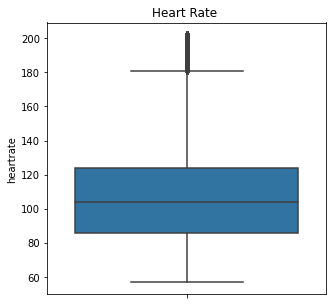

In [22]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(5,5))
plt.title("Heart Rate ")
ax = sns.boxplot(y=dataset2["heartrate"])

/Users/rakhee/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='heartrate'>

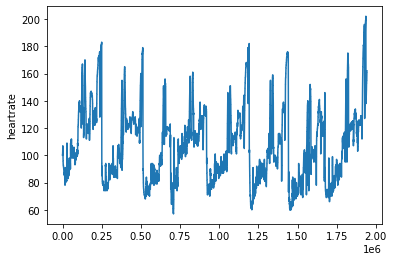

In [23]:
sns.lineplot(range(len(dataset2['heartrate'])),dataset2['heartrate'])

/Users/rakhee/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='heartrate'>

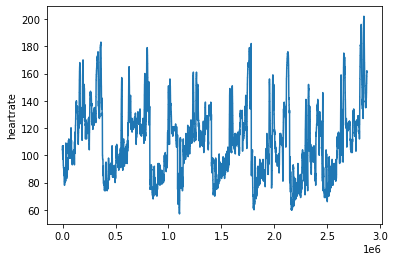

In [24]:
sns.lineplot(range(len(dataset['heartrate'])),dataset['heartrate'])

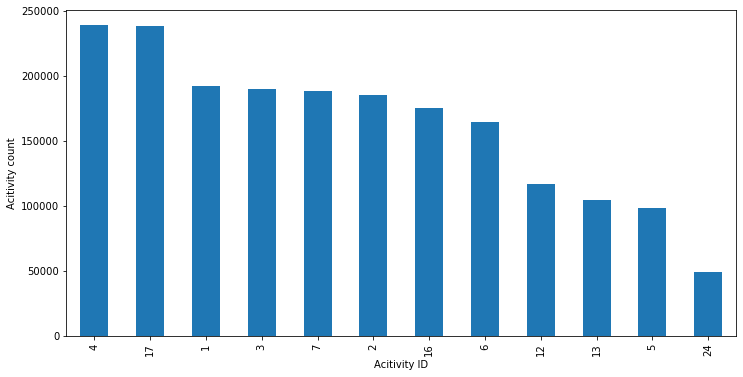

In [25]:
dataset2['activityID'].value_counts().plot(kind = "bar",figsize = (12,6))
plt.ylabel('Acitivity count')
plt.xlabel('Acitivity ID')
plt.show()

<AxesSubplot:xlabel='activityID', ylabel='Heartrate'>

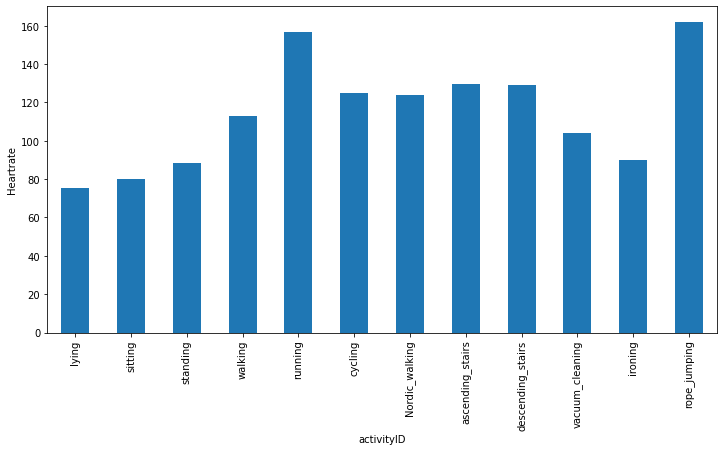

In [26]:
Hr_activity = dataset2['heartrate'].groupby(dataset2['activityID']).mean()
Hr_activity.index = Hr_activity.index.map(activityIDdict)
plt.ylabel('Heartrate')
Hr_activity.plot(kind='bar',figsize = (12,6))


/Users/rakhee/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/rakhee/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/rakhee/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


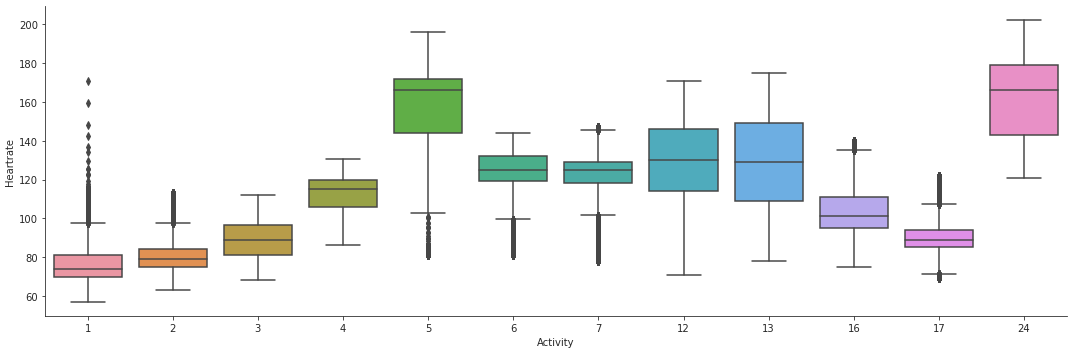

In [27]:
with sns.axes_style(style='ticks'):
    g = sns.factorplot("activityID", "heartrate", data=dataset2, kind = 'box', size=5, aspect=3)
    g.set_axis_labels("Activity", "Heartrate")

<AxesSubplot:xlabel='subject_id', ylabel='Heartrate'>

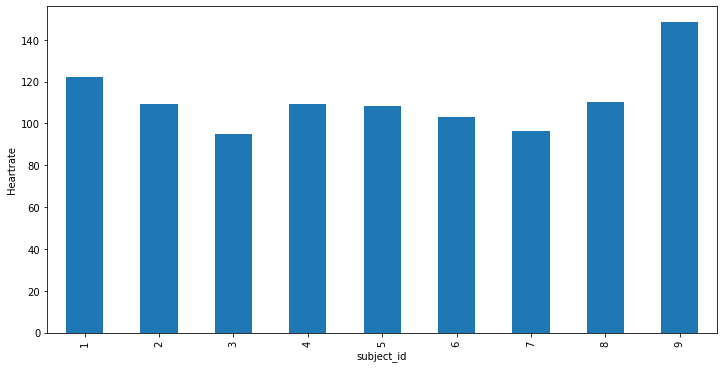

In [28]:
Sub_heartrate = dataset2['heartrate'].groupby(dataset2['subject_id']).mean()
#Sub_heartrate.index = Sub_heartratey.index.map(subject_id)
plt.ylabel('Heartrate')
Sub_heartrate.plot(kind='bar',figsize = (12,6))


In [29]:
dataset2_corr = dataset2.corr()
dataset2.corr()

,timestamp,activityID,heartrate,handtemp,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,...,ankleAcc6_1,ankleAcc6_2,ankleAcc6_3,ankleGyro1,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,subject_id
timestamp,1.000000,0.143712,0.781720,-0.493674,-0.321940,0.039321,-0.215706,-0.332616,0.036865,-0.226055,...,0.343229,0.218812,0.003066,0.001594,-0.045435,-0.001125,-0.308442,-0.234251,-0.041953,-0.022949
activityID,0.143712,1.000000,0.265348,0.159352,-0.129905,0.038609,-0.116724,-0.129179,0.042104,-0.118394,...,0.144746,0.103893,0.099199,-0.004876,0.012900,0.001905,-0.199631,-0.069626,0.209897,-0.001891
heartrate,0.781720,0.265348,1.000000,-0.395932,-0.298458,0.065728,-0.268278,-0.307739,0.063252,-0.277938,...,0.297939,0.211036,-0.009076,0.001228,-0.028440,0.001550,-0.325755,-0.247339,-0.056973,-0.127993
handtemp,-0.493674,0.159352,-0.395932,1.000000,0.059130,-0.053288,0.077812,0.073200,-0.048332,0.094127,...,-0.061476,-0.053106,-0.042125,-0.000417,0.033085,0.001882,0.092230,0.112293,0.154059,0.154094
handAcc16_1,-0.321940,-0.129905,-0.298458,0.059130,1.000000,-0.085483,0.257433,0.978695,-0.080322,0.261275,...,-0.320398,-0.101164,-0.013885,0.038499,-0.072116,0.093352,0.084533,0.206595,-0.042602,-0.030536
handAcc16_2,0.039321,0.038609,0.065728,-0.053288,-0.085483,1.000000,-0.067639,-0.070139,0.945219,-0.070711,...,0.060863,0.127373,0.007775,-0.004623,-0.031042,-0.037152,-0.049024,-0.096015,0.041010,-0.281382
handAcc16_3,-0.215706,-0.116724,-0.268278,0.077812,0.257433,-0.067639,1.000000,0.254849,-0.067663,0.964548,...,-0.164375,-0.075457,0.023768,0.012820,-0.011710,0.023692,0.060863,0.108253,-0.011762,-0.002032
handAcc6_1,-0.332616,-0.129179,-0.307739,0.073200,0.978695,-0.070139,0.254849,1.000000,-0.075857,0.258160,...,-0.314685,-0.100935,-0.013800,0.039194,-0.070733,0.082080,0.085498,0.211722,-0.039436,-0.028407
handAcc6_2,0.036865,0.042104,0.063252,-0.048332,-0.080322,0.945219,-0.067663,-0.075857,1.000000,-0.057245,...,0.057046,0.130811,0.009622,-0.002519,-0.032122,-0.013802,-0.052534,-0.099627,0.043655,-0.299075
handAcc6_3,-0.226055,-0.118394,-0.277938,0.094127,0.261275,-0.070711,0.964548,0.258160,-0.057245,1.000000,...,-0.170112,-0.075637,0.021927,0.012257,-0.011419,0.025473,0.062323,0.112929,-0.009647,0.003984


<AxesSubplot:>

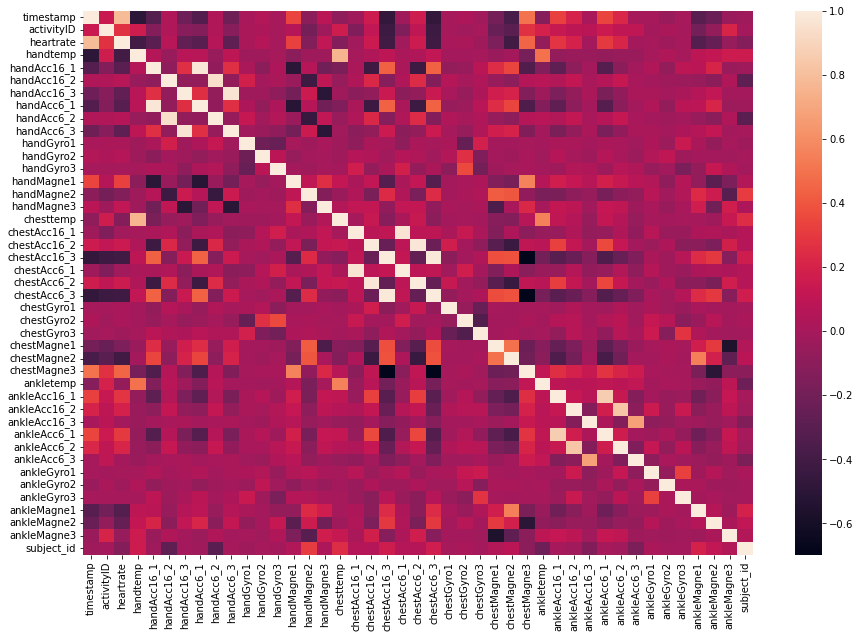

In [30]:
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(dataset2.corr())

In [31]:
df_new=dataset2.filter(['heartrate','ankletemp','chesttemp','handtemp'])

In [32]:
df_new.corr()

,heartrate,ankletemp,chesttemp,handtemp
heartrate,1.000000,-0.062178,-0.127371,-0.395932
ankletemp,-0.062178,1.000000,0.549366,0.495376
chesttemp,-0.127371,0.549366,1.000000,0.757514
handtemp,-0.395932,0.495376,0.757514,1.000000


<AxesSubplot:>

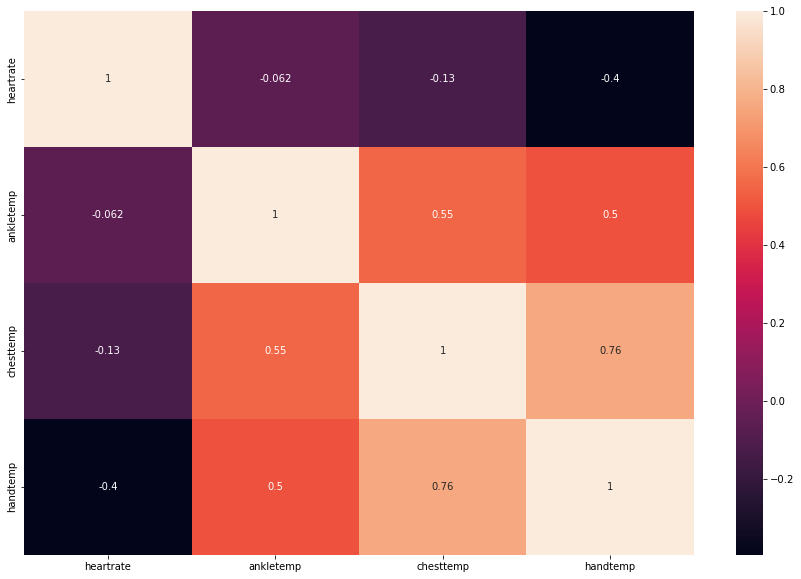

In [33]:
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df_new.corr(),annot=True)

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

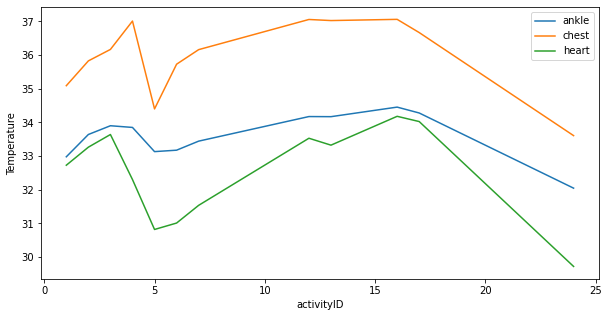

In [34]:
a=dataset2['ankletemp'].groupby(dataset2['activityID']).mean()
c=dataset2['chesttemp'].groupby(dataset2['activityID']).mean()
h=dataset2['handtemp'].groupby(dataset2['activityID']).mean()
a.plot(kind='line',figsize = (10,5),label = 'ankle')
c.plot(kind='line',figsize=(10,5),label='chest')
h.plot(kind='line',figsize=(10,5),label='heart')
plt.ylabel('Temperature')
plt.legend()
plt.plot


# Hypothesis Testing


Hypothesis testing is finding the p- value or the probability of the results for accepting the question raised by null hypothesis. The hypothesis testing can be one sided or two sided. A one tail hypothesis is considered when large change is unexpected, and a two tailed hypothesis is considered when the change is expected or if we are unsure. The alpha value is a prechosen value to determine the probability after data collection and before testing the hypothesis. Conventionally the 5% (less than 1 in 20 chance of being wrong), 1% and 0.1% (P < 0.05, 0.01 and 0.001) levels have been used. If the p-value for hypothesis is less than the alpha value, then the HO or null hypothesis is rejected as there is reasonable evidence to support the alternative hypothesis. Whereas if the p-value is more than the chosen alpha value, then we accept the Ho, or null hypothesis.
Based on the exploratory data analysis, few hypothesis can be tested. The individual heartrate varies depending on the activities. Also, few relations have been observed with activities and other sensors.


Ho= Heartrate for ropejumping is equal to  mean heartrate
Ha= Heartrate for ropejumping is more than mean heartrate
confidence level= 0.05

In [35]:
print(dataset2['heartrate'].mean())

107.48790990863012


In [36]:
from statsmodels.stats.weightstats import ztest as ztest

In [37]:
ztest(dataset2[dataset2.activityID==5].heartrate,value=107.48)

(675.6816979467034, 0.0)

The p-value for the above hypothesis in 0 which is less than the alpha value of 0.05. Thus we reject null hypothesis. Thus the heartrate of running is more than mean heartrate.

Hypothesis 2
Ho= Heartrate for walking is equal mean heartrate
Ha= Heartrate for walking is more than mean heartrate
confidence level= 0.05

In [38]:
ztest(dataset2[dataset2.activityID==4].heartrate,value=107.48)

(272.0164873460667, 0.0)

The p-value for the above hypothesis in 0 which is less than the alpha value of 0.05. Thus we reject null hypothesis. Thus the heartrate of walking is more than mean heartrate.

I have considered two hypothesis to understand the performance of heartrate during various activities. In the first one tailed hypothesis, the p-value for is  0 which is less than the alpha value of 0.05. So we reject null hypothesis and accept alternate hypothesis that the heartrate of running is more than mean heartrate.
In the second hypothesis, the null hypothesis was that walking heartrate is equal to mean heartrate. The p-value for the above hypothesis is 0 which is less than the alpha value of 0.05. So we reject null hypothesis and accept the alternate hypothesis. Thus the heartrate of walking is more than mean heartrate.
It is known that as the sample size increases the standard error decreases and if there is increase in the difference between the sample statistic and hypothesis parameters, the p-value decreases. Thus, this increases the chance of the null hypothesis being rejected.



# Modelling

The exploratory data analysis highlights the treads and provides insights into the data. This is used to manipulate data for developing model. The data set is now divided into training and testing in the ratio of 80:20
The data is pre-processed before it can be used building model and checking its performance First, PCA Principal component analysis is carried out to reflect the strongest features on which the model will be build. The PCA reduced features from 40  to 27 features, highlighting the variance ration. Then,Standardscalar is used to scale the magnitude of features to the required scale.


In [39]:
train_df = dataset2.sample(frac=0.8, random_state=1)
test_df = dataset2.drop(train_df.index)

In [40]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing


In [41]:
train_df = train_df.drop(["timestamp", "subject_id"],1)

/var/folders/87/rxjkhzbs2qn6qpn_1mhl4t040000gp/T/ipykernel_10274/1730545918.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  train_df = train_df.drop(["timestamp", "subject_id"],1)


In [42]:
scaler = StandardScaler()
df_scaled = train_df #X
df_scaled_test = test_df #y

df_scaled.iloc[:,1:41] = scaler.fit_transform(df_scaled.iloc[:,1:41])
df_scaled_test.iloc[:,1:41] = scaler.fit_transform(df_scaled_test.iloc[:,1:41])

df_scaled.head(10)

,activityID,heartrate,handtemp,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,handGyro1,...,ankleAcc16_3,ankleAcc6_1,ankleAcc6_2,ankleAcc6_3,ankleGyro1,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3
452630,3,-0.647483,0.800420,-0.573201,0.164235,-0.819889,-0.539318,0.210218,-0.759382,-0.011658,...,0.270934,0.056339,-0.204290,0.336270,0.061263,0.051367,-0.040858,0.700665,-0.842780,0.992965
191799,12,2.239076,0.521746,-1.006208,-0.089085,-0.322998,-0.875447,-0.090000,-0.378825,-0.470403,...,0.058770,0.290531,-0.175026,-0.097208,-0.254793,1.106749,-0.074206,-1.097854,1.496236,-1.209677
1780187,24,2.724099,0.591414,0.508669,0.019698,-2.777108,0.690751,0.058897,-2.023876,-2.787048,...,1.386408,-2.226846,-0.551591,1.248103,1.657804,-0.219063,-0.327874,-0.712213,-0.627741,-0.862145
1805604,1,-1.684893,0.382408,1.577989,-0.551536,1.179822,1.604587,-0.594582,1.218875,0.030036,...,-0.203822,-1.564516,-1.303984,-0.190078,-0.016240,0.060506,0.006039,0.777109,1.155267,-1.118810
2504609,2,-1.055037,0.870089,0.479006,-1.897773,-0.685707,0.493796,-1.980153,-0.691807,-0.013352,...,-0.031703,-0.030892,0.410306,0.006393,-0.000061,0.074967,0.011588,0.661830,0.665577,0.444251
1432439,1,-1.055037,1.183598,0.919965,0.579611,0.583955,0.953278,0.597543,0.637628,0.002789,...,-0.519288,-1.595077,-1.241041,-0.556006,0.031700,0.035673,0.001729,0.948550,1.225067,-1.175953
918517,3,-0.957359,-0.105273,-0.600793,-0.059013,-0.342773,-0.592817,-0.057537,-0.383227,0.075334,...,0.308585,0.081314,0.018933,0.395520,0.023529,0.390893,-0.050084,1.362097,-0.207909,0.285154
514905,16,-0.128778,0.974592,-1.299277,-0.073920,-0.991212,-1.174723,0.014895,-1.017905,-1.739461,...,2.222591,0.029621,0.129709,2.585663,-0.150961,0.402261,-0.040519,0.898388,-0.150347,0.459063
96841,17,-0.388131,0.312740,1.734341,0.179642,-1.057203,1.779137,0.106952,-1.195259,-0.220710,...,0.829587,0.062536,-0.039763,0.835906,-0.073990,-0.280336,-0.011896,-1.375285,-0.773460,1.229579
101735,17,-0.314030,0.312740,-0.000757,-0.188015,1.111242,-0.015509,-0.060660,1.097067,-0.738542,...,0.064614,0.013596,-0.233936,0.066874,0.045506,0.091604,-0.012179,-1.173333,-0.546205,1.720955


In [43]:
X_train = df_scaled.drop('activityID', axis=1).values
y_train = df_scaled['activityID'].values

# Test Dataset
X_test = df_scaled.drop('activityID', axis=1).values
y_test = df_scaled['activityID'].values

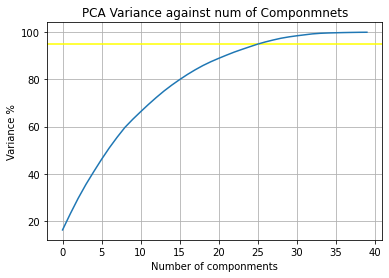

In [44]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train)
v= pca.explained_variance_ratio_  #ratio indicates prop of datasetvariance that loies along each principal component
var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

plt.title("PCA Variance against num of Componmnets")
plt.ylabel("Variance %")
plt.xlabel("Number of componments")
l = plt.axhline(95, color="yellow")
plt.plot(var)
plt.grid()

In [45]:
X_train.shape

(1554298, 40)

In [46]:
from sklearn.decomposition import PCA
pca = PCA(0.95)
X_pca=pca.fit_transform(X_train)
X_pca.shape

(1554298, 27)

In [47]:
pca.explained_variance_ratio_

array([0.16175122, 0.06878474, 0.06510367, 0.05934718, 0.05398315,
       0.05222513, 0.04895345, 0.04494801, 0.04182949, 0.03421729,
       0.03178444, 0.03089278, 0.02935485, 0.02773413, 0.02522641,
       0.02323558, 0.02176275, 0.0199187 , 0.0181502 , 0.01590667,
       0.01433924, 0.01360045, 0.01295068, 0.01159961, 0.01118273,
       0.01098196, 0.009351  ])

In [48]:
pca1 = PCA(n_components=27)
X_train_new=pca1.fit_transform(X_train)
X_test_new=pca1.fit_transform(X_test)

# Modelling

Initially, K- means cluster model is used to identify distinct and non-overlapping groups. The idea being the less the intracluster distance the more related the data. The elbow method for determining the feature cluster, identified 2 clusters for the data. Three graphs of K- clusters were plotted to understand the spread of data and  similar groups. The first cluster was mapped be using activity and hand temperature. It shows that activity - 4,5,6,7 which are running or walking activities were in one cluster while activities 2,3,16,17 which were lying, sitting and ironing were grouped together. While activity 12-13 which included the ascending and descending of stairs had mixed group colour indicating closeness with other clusters. This similarity of clustering was observed again when activity data was plotted against heartrate. The activities of walking, running, cycling and nordic walking were grouped together and ironing and vacuum cleaning were grouped together. Due to the significant similarity in the clusters we can assume that the activities have similar intensities and hence can be grouped together. On plotting timestamp with hand temperature, two distinct clusters were observed after timestamp of 18000.
Further,  to explore a cluster with k=3 was also created which produced 3 cluster for light, medium and high activity.

K- clusters though provided valuable information, it was observed that significant amount of data was clustered only in one cluster which is not ideal. Hence, another model was explored.


 Logistic regression model is a widely used model in biological sciences where the dependent variable is categorical. Hence this model was used as it allows the evaluation of multiple exploratory variables. The model gave a score of 0.824 when entire data set was used and reduced it to 0.077 when only the feature obtained from PCA were used.

Random forest model which is a model has been used. Random forest uses a collecting of decision trees which calculate a prediction for each class and the class with highest score becomes the model prediction. As this model uses multiple decision trees to get more stable and highly accurate prediction was used to analysis this multivariant data. The model performance was 1. A score of 1, indicates overfitting of the data and is not a recommended


In [49]:
import statsmodels.api as sm
sns.set()
from sklearn.cluster import KMeans

In [50]:
kmeans = KMeans(3)
kmeans.fit(X_train)

KMeans(n_clusters=3)

In [51]:
from sklearn.cluster import KMeans
K=3
Kmean = KMeans(n_clusters=3)
Kmean.fit(X_train)

KMeans(n_clusters=3)

In [53]:
Kmean.cluster_centers_

array([[ 4.55679562e-01, -2.93881181e-01, -4.90260199e-01,
        -2.72049523e-02, -4.33084581e-01, -4.96690346e-01,
        -2.48730941e-02, -4.38877887e-01, -1.70011658e-02,
         4.19329962e-02,  1.58368322e-02,  5.77514114e-01,
         5.06662208e-02,  3.71676376e-01, -4.25490333e-02,
         7.34039327e-02,  9.06292566e-02, -3.42700648e-01,
         7.50925204e-02,  9.29144414e-02, -3.43878119e-01,
         9.58954954e-03,  6.79329646e-02, -3.09297078e-02,
        -1.24003005e-01, -1.63139609e-01,  4.70669459e-01,
        -7.32455007e-02,  2.25168585e-01,  1.63784905e-01,
        -2.23422669e-02,  2.41578848e-01,  1.72359846e-01,
        -2.81472042e-02,  2.24810079e-02, -3.13267235e-02,
        -1.96975286e-02, -7.51380925e-02, -2.94219718e-01,
        -1.48659021e-01],
       [-1.19532885e+00,  3.29490710e-03,  1.50585094e+00,
        -2.27403203e-01,  8.67396321e-01,  1.51241400e+00,
        -2.40412412e-01,  8.81255633e-01, -3.38035685e-03,
        -3.86627575e-02, -7.62

<AxesSubplot:xlabel='activityID', ylabel='heartrate'>

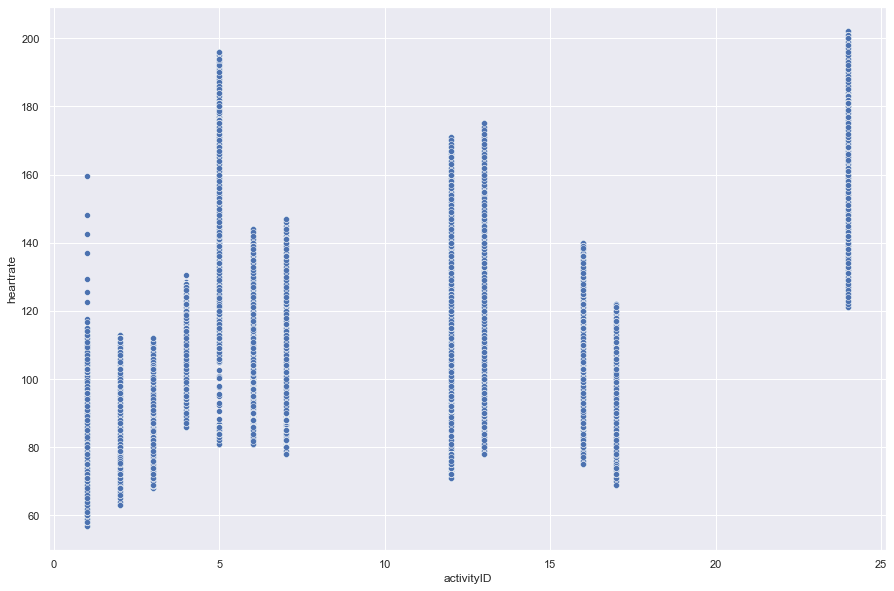

In [54]:
A=dataset2.sample(frac=0.8, random_state=1)
f, ax = plt.subplots(figsize=(15, 10))
#plt.scatter(A['timestamp'],A['heartrate'])
sns.scatterplot(data=A, x="activityID", y="heartrate")
#plt.show()

<AxesSubplot:xlabel='timestamp', ylabel='handtemp'>

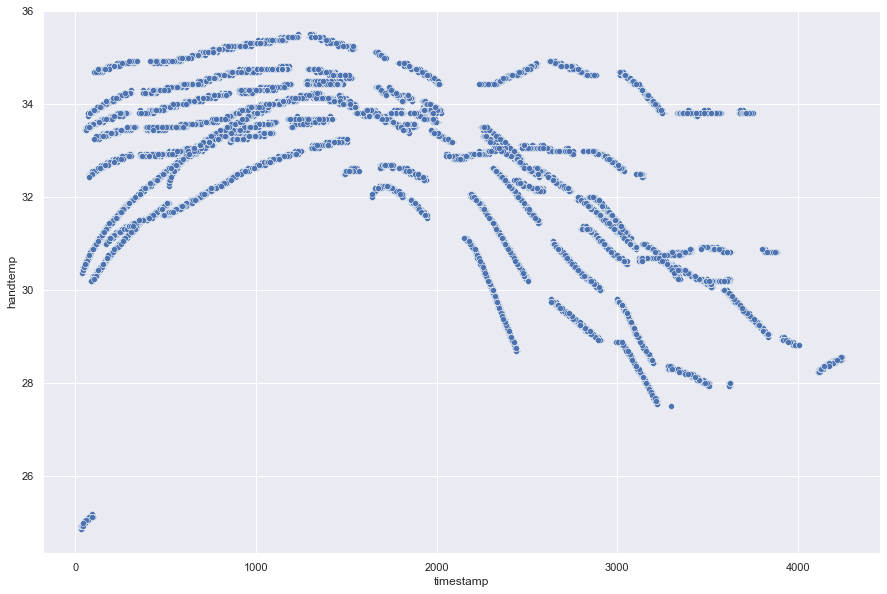

In [55]:
f, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=A,x='timestamp',y='handtemp')

In [56]:
import statsmodels.api as sm
sns.set()
from sklearn.cluster import KMeans

In [57]:
x = A.iloc[:,0:4] # 1t for rows and second for columns

x

,timestamp,activityID,heartrate,handtemp
452630,767.77,3,90.000000,34.1875
191799,1926.37,12,167.909091,33.6875
1780187,3749.31,24,181.000000,33.8125
1805604,255.84,1,62.000000,33.4375
2504609,491.73,2,79.000000,34.3125
...,...,...,...,...
1154689,790.10,3,103.000000,33.2500
2242532,1006.98,17,82.000000,33.8125
467500,916.47,17,106.000000,34.3125
2589608,1341.72,16,100.000000,34.7500


Text(0, 0.5, 'WCSS')

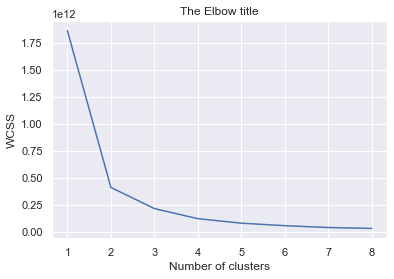

In [58]:
wcss=[]
for i in range(1,9):
    kmeans = KMeans(i)
    kmeans.fit(x)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)

number_clusters = range(1,9)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [59]:
## import statsmodels.api as sm
sns.set()
from sklearn.cluster import KMeans
kmeans = KMeans(2)
kmeans.fit(x)

KMeans(n_clusters=2)

In [60]:
id_clusters = kmeans.fit_predict(x)
id_clusters

array([1, 0, 0, ..., 1, 1, 1], dtype=int32)

In [61]:
cluster_data = A.copy()
cluster_data['Clusters'] = id_clusters

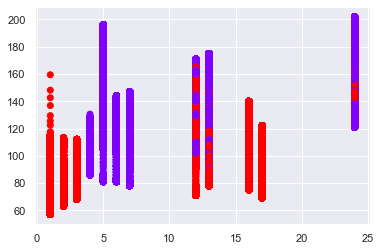

In [62]:
plt.scatter(cluster_data['activityID'],cluster_data['heartrate'],c=cluster_data['Clusters'],cmap='rainbow')

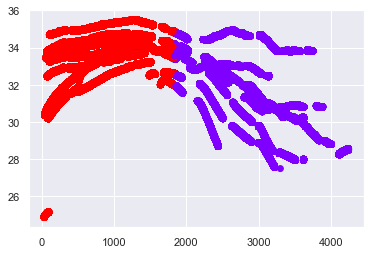

In [63]:
plt.scatter(cluster_data['timestamp'],cluster_data['handtemp'],c=cluster_data['Clusters'],cmap='rainbow')

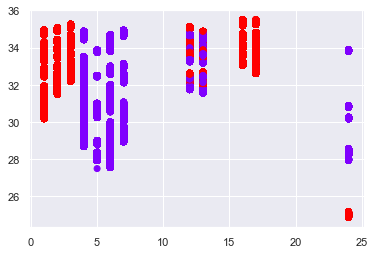

In [64]:
plt.scatter(cluster_data['activityID'],cluster_data['handtemp'],c=cluster_data['Clusters'],cmap='rainbow')

In [65]:
x = A.iloc[:,0:4] # 1t for rows and second for columns

kmeans = KMeans(3)
kmeans.fit(x)
id_clusters = kmeans.fit_predict(x)
id_clusters

array([1, 2, 0, ..., 1, 2, 1], dtype=int32)

In [66]:
cluster_data = A.copy()
cluster_data['Clusters'] = id_clusters

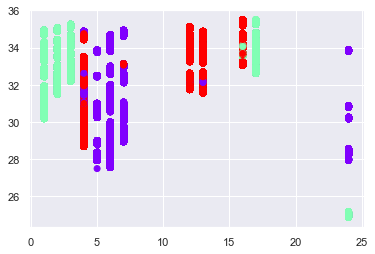

In [67]:
plt.scatter(cluster_data['activityID'],cluster_data['handtemp'],c=cluster_data['Clusters'],cmap='rainbow')

In [64]:
from sklearn.linear_model import LogisticRegression
model=LogisticRegression(max_iter=1000)
model.fit(X_train,y_train)
model.score(X_test,y_test)

0.8240794236369088

In [65]:

model=LogisticRegression(max_iter=1000)
model.fit(X_train_new,y_train)
model.score(X_test_new,y_test)

0.7730280808442139

In [66]:
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier


In [66]:
from sklearn.ensemble import RandomForestClassifier
model=RandomForestClassifier(n_jobs =3)
model.fit(X_train,y_train)
model.score(X_test,y_test)


1.0

In [71]:
from sklearn.metrics import precision_score,recall_score, f1_score, confusion_matrix,roc_auc_score,roc_curve, accuracy_score
def get_metrics (y_true,y_pred):
    acc = accuracy_score(y_true, y_pred)
    err = 1-acc
    p = precision_score(y_true, y_pred,average=None).mean()
    r = recall_score(y_true, y_pred, average=None).mean()
    f1 = f1_score(y_true, y_pred, average=None).mean()
   
    print("Accuracy: ",acc)
    print("Error: ",acc)
    print("Precision", p)
    print("Recall", r)
    print("F1", f1)

In [72]:
log_reg = LogisticRegression()
log_reg.fit(X=X_train, y=y_train )
y_pred_lr = log_reg.predict(X_test)
get_metrics(y_test, y_pred_lr)

/Users/rakhee/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy:  0.8240684862233626
Error:  0.8240684862233626
Precision 0.8018861274441892
Recall 0.7885079114324608
F1 0.7939326973550537


In [73]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_jobs =4)
rfc.fit(X_train,y_train)
y_pred_rf = rfc.predict(X_test)
get_metrics(y_test,y_pred_rf)

Accuracy:  1.0
Error:  1.0
Precision 1.0
Recall 1.0
F1 1.0


In [74]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

classifiers = [LogisticRegression(),
               RandomForestClassifier(n_jobs =4)]

score_lst = []
for cls in classifiers:
    accs  = accuracy_score(y_train, cross_val_predict(cls,X_train,y_train,cv = 10))  #cross validate the accurancy 
    scores = cross_val_score(cls,X_train,y_train,scoring = "neg_mean_squared_error",cv= 10)#calcuate the error
    score = np.sqrt(-scores)
    f1 = cross_val_score(cls,X_test, y_test,scoring = "f1_macro", cv =10)
    
    
    #p = cross_val_score(cls,X_test, y_test,scoring = "average_precision", cv =10)
#     r = recall_score(y_true, y_pred, average=None).mean()
#     f1 = f1_score(y_true, y_pred, average=None).mean()
    score_lst.append([cls.__class__.__name__,accs,score.mean(), f1.mean()])

df_scores=pd.DataFrame(columns = ["Claasifier","Accurancy","MSE","F1"],data =  score_lst)
display(df_scores)

/Users/rakhee/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/rakhee/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

KeyboardInterrupt: 

The PAMAP dataset has numerous measurements. The data collected had a large proportion of null and missing values. The missing values in heartrate column were filled using interpolation while missing values in other columns were filled as zero. Columns which did not add any valuable information were deleted. These included activity category-0, ang orientation columns. Exploratory data analysis was carried out to for in-depth analysis of data and to understand the most prominent and contributing features of the dataset. Heartrate, hand temperature, timestamps showed strong correlations. These features were further explored with cluster modelling.
As, the data has various features, Principal component analysis was carried out which condensed the most important features from 40 to 27.
K-means clustering was conducted. Using the elbow method for the data, 2 clusters were identified. These clusters identified activates which were closely related to intensity. Further, a cluster with k=3 was also created which produced 3 cluster for light, medium and high activity.
As, Logistic regression model uses multiple variables, it was used as a model for the data, The performance of the model was 0.83 which later reduced to 0.73 when the PCA data of 27 features was used.
Random forest model was also trialled which produced a score of 1. This score indicated over fitting of data.

It is observed that heartrate, activity, timestamps and the hand temperatures are strong features. While performing activities, the hand temperature showed a strong corelation with the heat rate. Thus, we can record the individual movements and temperature changes during activity and its effect on heartrate. The time stamps indicate the duration for which a certain activity was performed, and the intensity can be recorded with the heartrate activity. An increase in heartrate indicates higher cardio activity and better metabolism rate and more calories burnt. This can help individual participants to monitor their health performance 

Thus, using hardware to monitor movement during activity and a software to process this information we can  analyse individual performance improving health benefits.


Refrences
http://archive.ics.uci.edu/ml/datasets/pamap2+physical+activity+monitoring

https://towardsdatascience.com/logistic-regression-detailed-overview-46c4da4303bc

https://www.statsdirect.co.uk/help/basics/p_values.htm

https://towardsdatascience.com/understanding-random-forest-58381e0602d2